## Data loading and cleaning

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [2]:
data = pd.read_csv("C:/B.Tech Projects/2nd year/ML & AISR/Sentimental analysis using svm/Tweets.csv")

In [3]:
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['sentiment'] = data_clean['airline_sentiment'].\
    apply(lambda x: 1 if x=='negative' else 0)

data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

C:\Users\M Amruth Sai\AppData\Local\Temp\ipykernel_3760\2442227045.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)


We are going to distinguish two cases: tweets with negative sentiment and tweets with non-negative sentiment

In [4]:
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x=='negative' else 0)

In [5]:
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]

In [6]:
data_clean.head()

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1


## Machine Learning Model

In [7]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

In [8]:
print(y_train)

1241     1
4711     1
9943     0
6455     0
11285    1
        ..
986      1
5593     1
13083    1
251      1
14325    0
Name: sentiment, Length: 10920, dtype: int64


In [9]:
print(y_test)

11525    1
13552    0
723      0
11786    0
9004     0
        ..
2207     1
3328     0
10451    1
7068     0
3501     1
Name: sentiment, Length: 2731, dtype: int64


In [10]:
import nltk
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1002)>


False

In [11]:
def tokenize(text):
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english"))

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = 'english')  # No syntax errors here, comment removed

We are going to use cross validation and grid search to find good hyperparameters for our SVM model. We need to build a pipeline to don't get features from the validation folds when building each training model.

In [12]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [13]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer,
                             SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                        param_grid={'svc__C': [0.01, 0.1, 1]},
                        cv=kfolds,
                        scoring="roc_auc",
                        verbose=1,
                        n_jobs=-1)

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\M Amruth Sai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9183083971047707

In [14]:
grid_svm.best_params_

{'svc__C': 0.1}

In [15]:
grid_svm.best_score_

0.9011789175532743

In [16]:
from sklearn.metrics import accuracy_score
print(f"Accuracy : {accuracy_score(grid_svm.predict(X_test),y_test)*100}")

Accuracy : 83.55913584767485


In [17]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

Let's see how the model (with the best hyperparameters) works on the test data:

In [18]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.9183153255084544,
 'f1': 0.8700434153400868,
 'acc': 0.8355913584767485,
 'precision': 0.918142944410507,
 'recall': 0.8267326732673267}

In [19]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [20]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

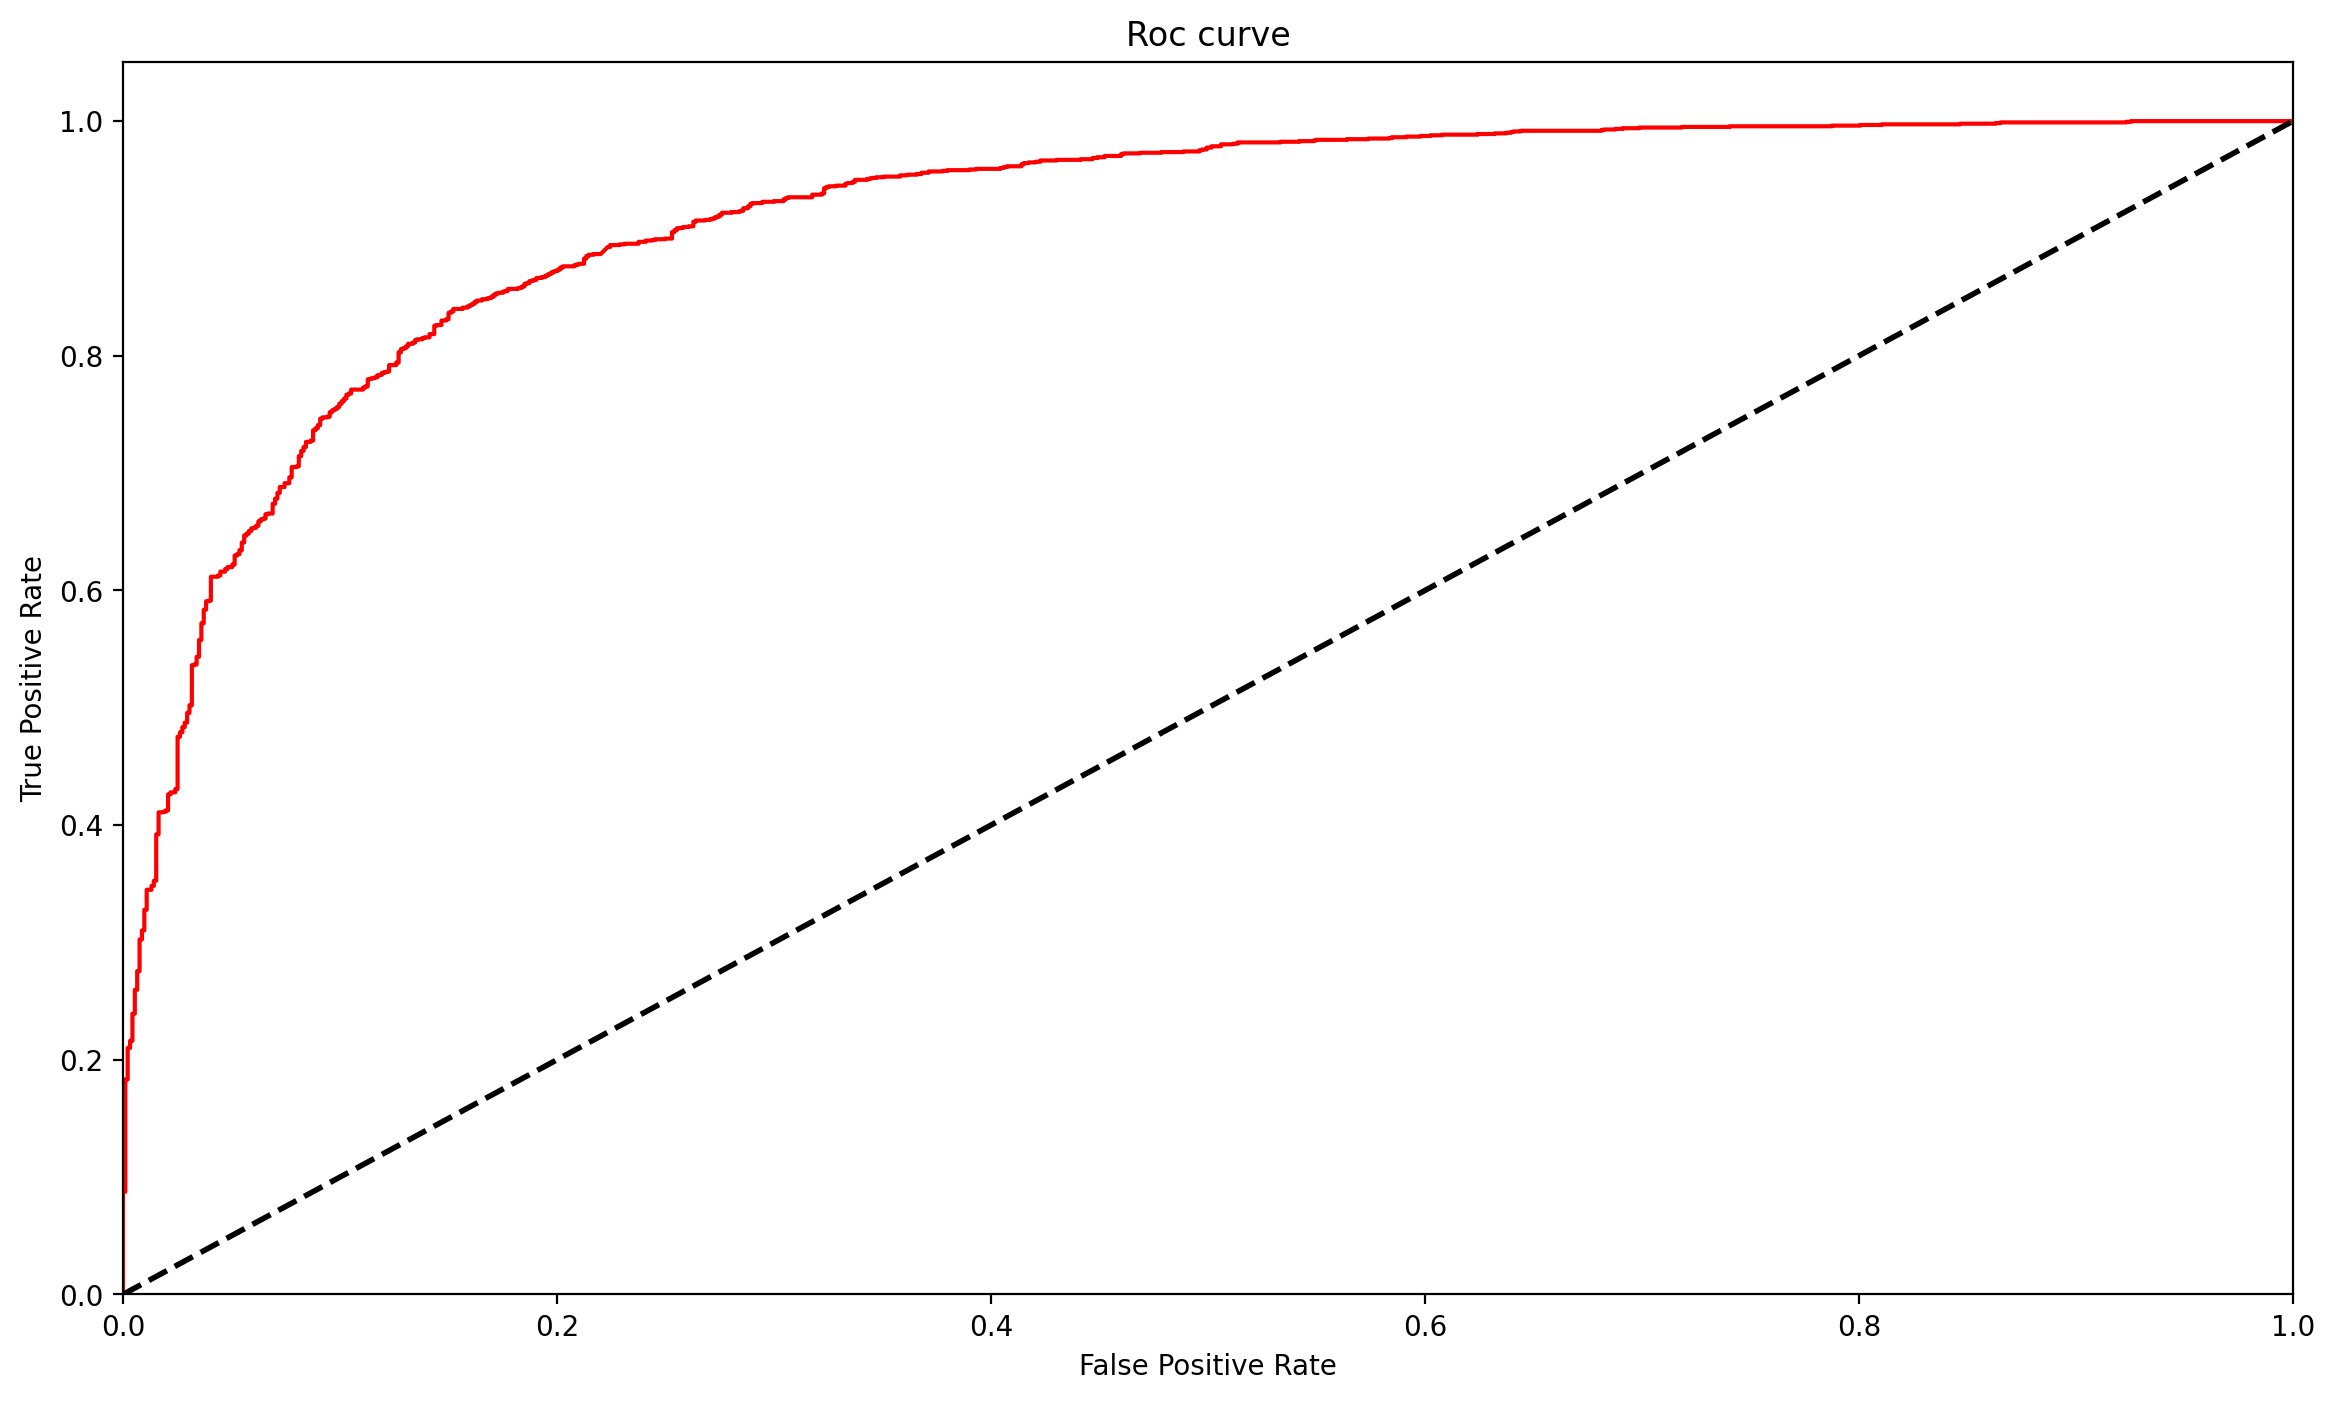

In [38]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [22]:
from collections import Counter

# Assuming y_train contains the labels (sentiments)
label_counts = Counter(y_train)

# Count the occurrences of each label
num_ones = label_counts[1]
num_zeros = label_counts[0]

print("Number of 1's in train set:", num_ones)
print("Number of 0's in train set:", num_zeros)


Number of 1's in train set: 6969
Number of 0's in train set: 3951


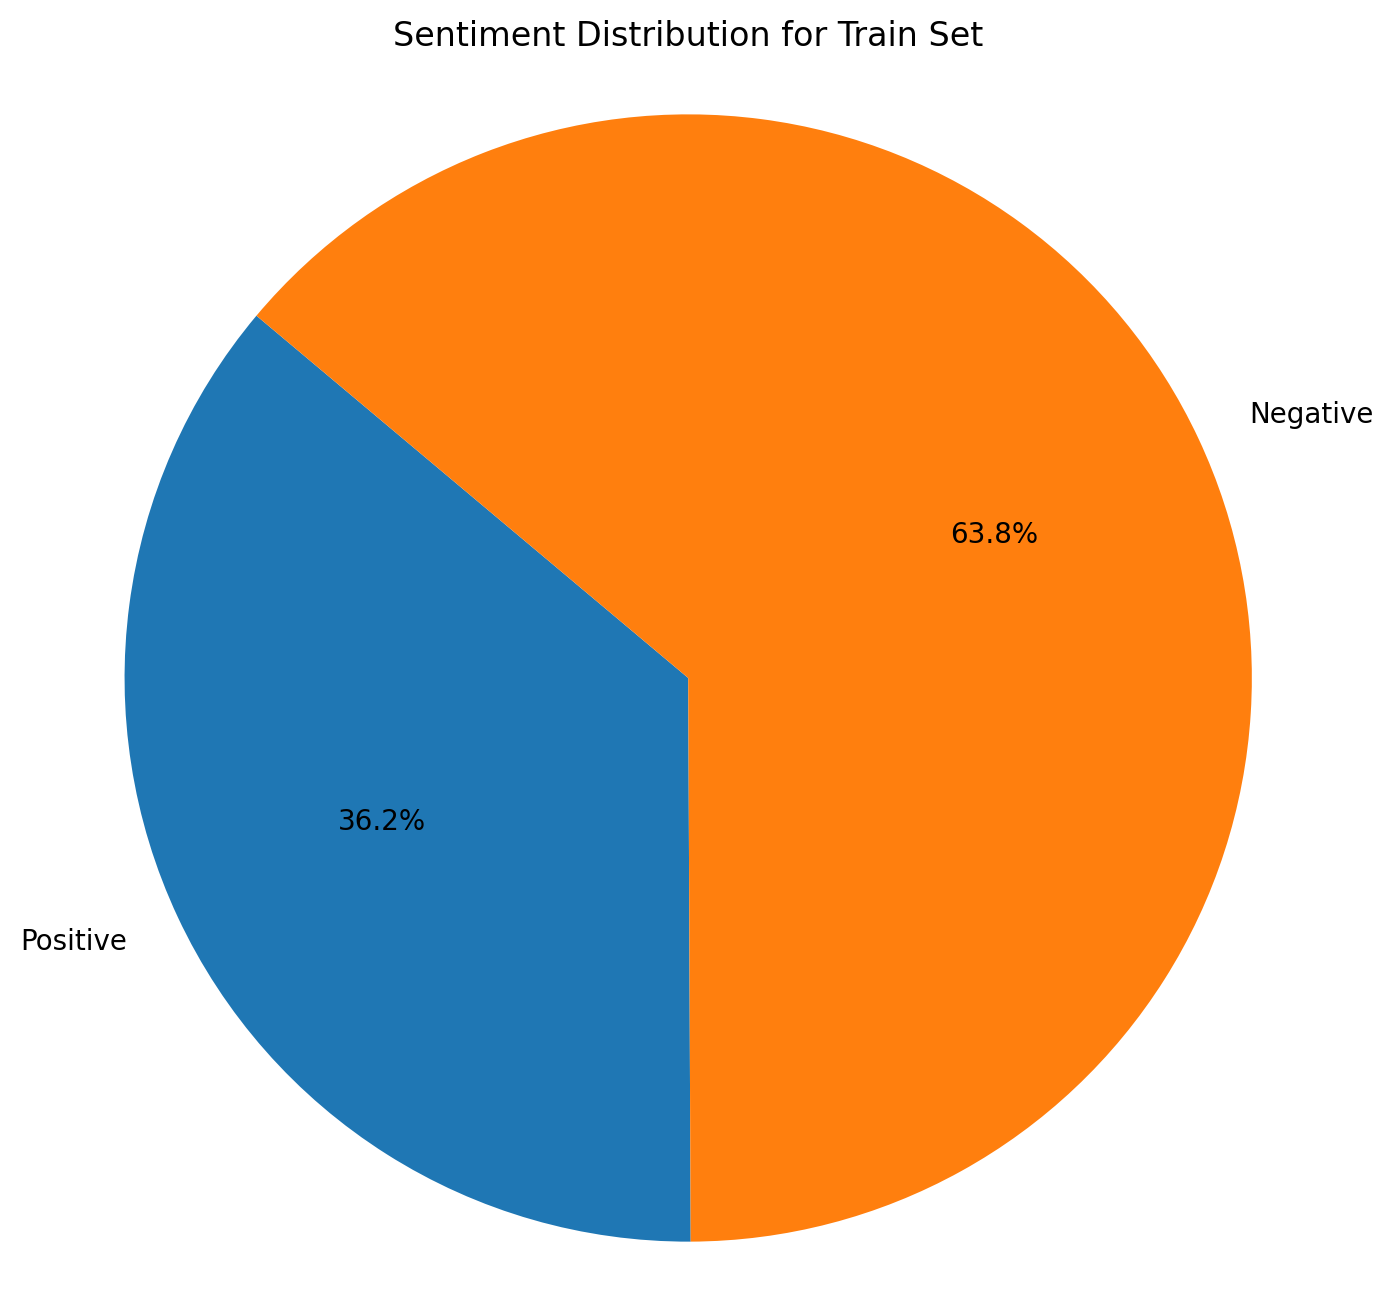

In [23]:
import matplotlib.pyplot as plt

# Example data
labels = ['Positive', 'Negative']
sizes = [3951, 6969]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution for Train Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [24]:
from collections import Counter

# Assuming y_test contains the labels (sentiments)
label_counts = Counter(y_test)

# Count the occurrences of each label
num_ones = label_counts[1]
num_zeros = label_counts[0]

print("Number of 1's in train set:", num_ones)
print("Number of 0's in train set:", num_zeros)

Number of 1's in train set: 1818
Number of 0's in train set: 913


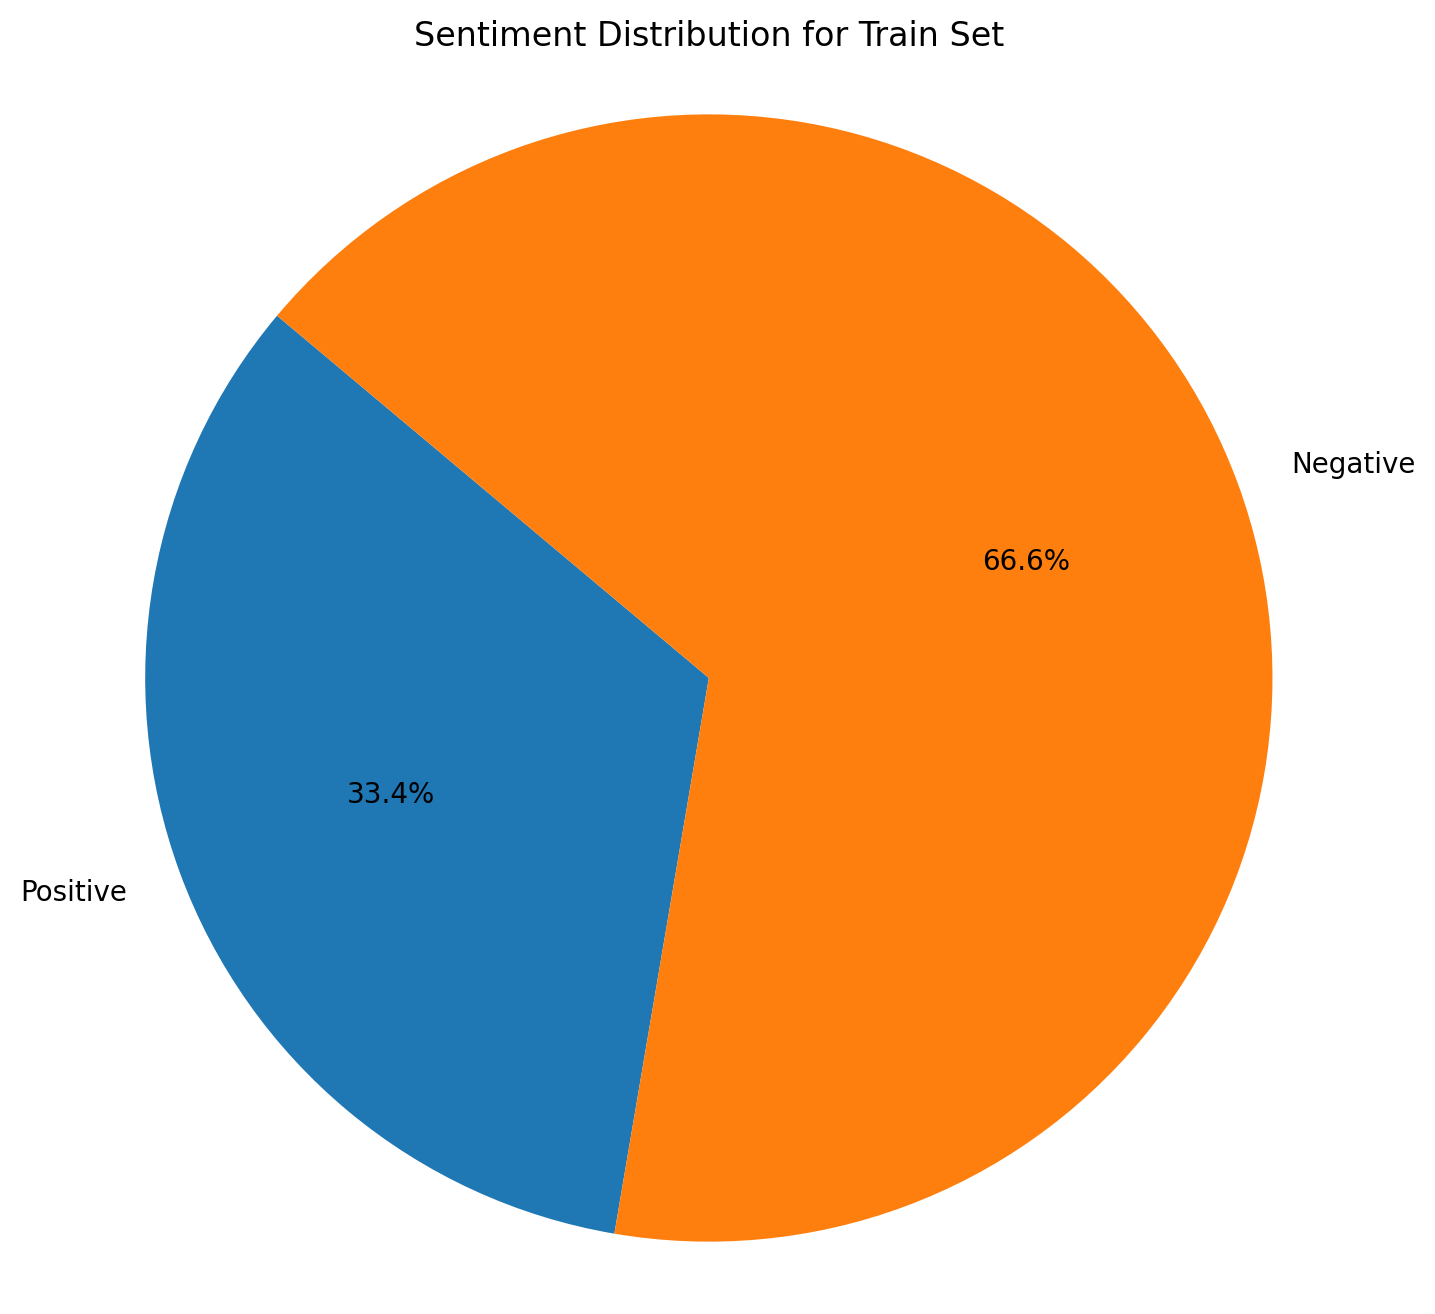

In [40]:
import matplotlib.pyplot as plt

# Example data
labels = ['Positive', 'Negative']
sizes = [913, 1818]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution for Train Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Let's see if our model has some bias or variance problem ploting its learning curve:

In [26]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1,
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [27]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

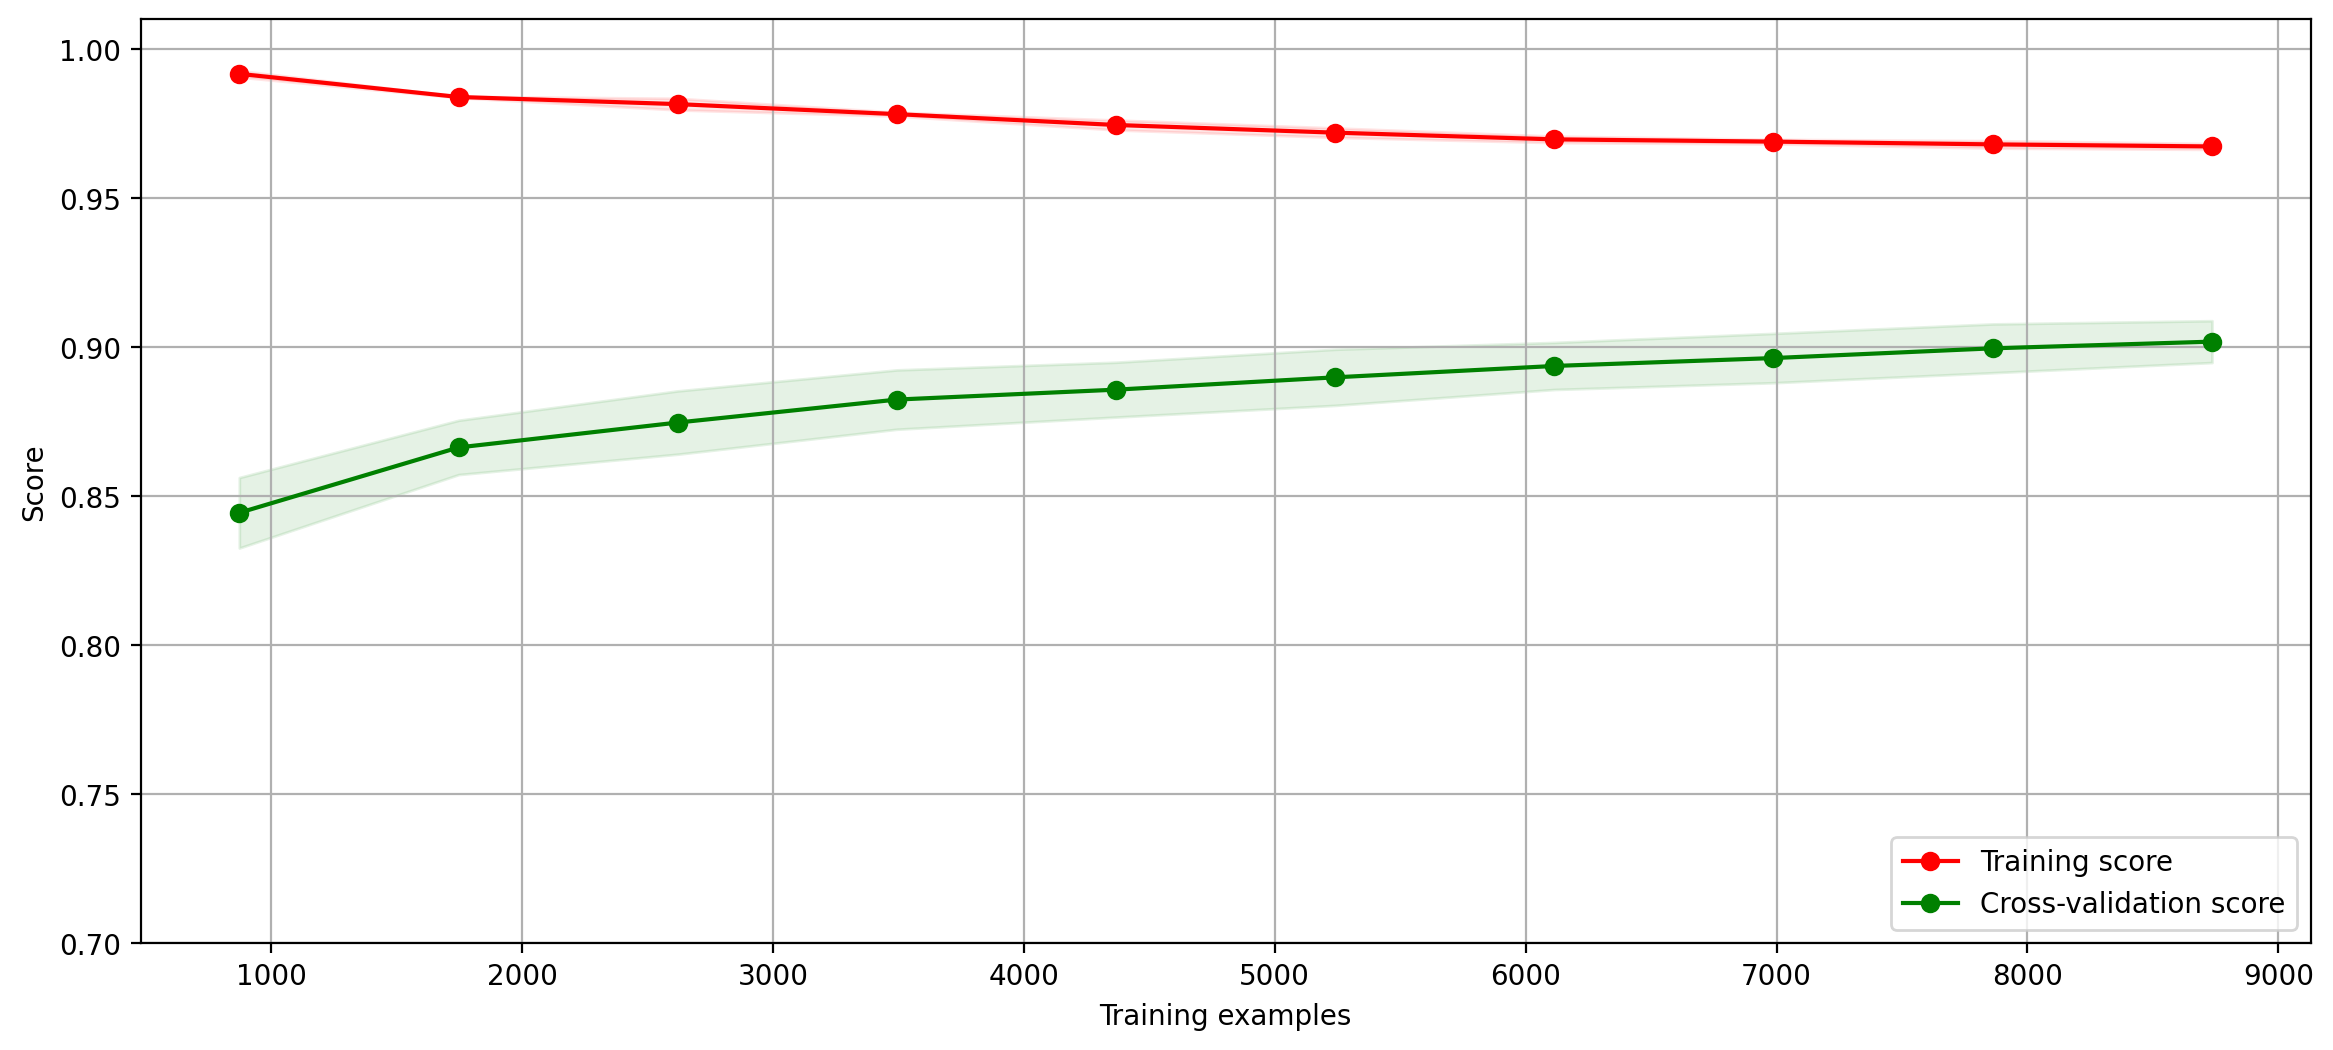

In [28]:
plot_learning_curve(X_train, y_train, train_sizes,
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

In [29]:
grid_svm.predict(["flying with @united is always a great experience"])

array([0], dtype=int64)

In [30]:
grid_svm.predict(["flying with @united is always a great experience. If you don't lose your luggage"])

array([1], dtype=int64)

In [31]:
grid_svm.predict(["I love @united. Sorry, just kidding!"])

array([0], dtype=int64)

In [32]:
grid_svm.predict(["@united very bad experience!"])

array([1], dtype=int64)

In [35]:
grid_svm.predict(["@united very bad experience!"])

array([1], dtype=int64)

In [37]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox

def predict_sentiment():
    text = text_entry.get()
    if text.strip() == "":
        messagebox.showerror("Error", "Please enter some text.")
    else:
        prediction = grid_svm.predict([text])
        if prediction[0] == 1:
            result_label.config(text="Negative sentiment", foreground="red")
        else:
            result_label.config(text="Positive sentiment", foreground="green")

def clear_text():
    text_entry.delete(0, tk.END)
    result_label.config(text="", foreground="black")

# Create the main application window
root = tk.Tk()
root.title("Sentiment Analysis")

# Set window size and position
window_width = 400
window_height = 200
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()
x_coordinate = (screen_width / 2) - (window_width / 2)
y_coordinate = (screen_height / 2) - (window_height / 2)
root.geometry("%dx%d+%d+%d" % (window_width, window_height, x_coordinate, y_coordinate))

# Set window background color
root.configure(bg="#f0f0f0")

# Create and place widgets
text_label = ttk.Label(root, text="Enter text:", background="#f0f0f0", font=("Helvetica", 12))
text_label.grid(row=0, column=0, padx=10, pady=10, sticky="w")

text_entry = ttk.Entry(root, width=40, font=("Helvetica", 12))
text_entry.grid(row=0, column=1, padx=10, pady=10)

predict_button = ttk.Button(root, text="Predict", command=predict_sentiment, style="TButton")
predict_button.grid(row=1, column=0, columnspan=2, pady=10)

clear_button = ttk.Button(root, text="Clear", command=clear_text, style="TButton")
clear_button.grid(row=2, column=0, columnspan=2, pady=5)

result_label = ttk.Label(root, text="", background="#f0f0f0", font=("Helvetica", 14, "bold"))
result_label.grid(row=3, column=0, columnspan=2)

# Set button styles
style = ttk.Style()
style.configure("TButton", font=("Helvetica", 12))

# Start the GUI event loop
root.mainloop()

